In [1]:
import cmocean 
import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:44053 Dashboard: /proxy/43341/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


Load datasets

In [2]:
session_ryf = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'
session_eas = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
experiment_edo = '01deg_jra55v13_ryf9091_easterlies_down10'
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
easterlies_up_meridional = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'

ti = '2150-01-01'
tf = '2159-12-31'

In [3]:
ht = cc.querying.getvar(experiment_ryf, 'ht', session_ryf, n = 1).sel(yt_ocean = slice(None, -58))

In [4]:
slev = {}
slev['ctrl'] = cc.querying.getvar(experiment_ryf, 'sea_level', session_ryf, start_time = '2149-07-01', end_time = tf).sel(time = slice('2149-07-01', tf), yt_ocean = slice(None, -58))
slev['up'] = cc.querying.getvar(experiment_eup, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
slev['up_zon'] = cc.querying.getvar(easterlies_up_zonal, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))
slev['up_mer'] = cc.querying.getvar(easterlies_up_meridional, 'sea_level', session_eas, start_time = ti, end_time = tf).sel(yt_ocean = slice(None, -58))

### Sea level

In [9]:
slev['up'] = xr.concat([slev['ctrl'].isel(time = slice(None, 6)), slev['up']], dim = 'time')
slev['up_zon'] = xr.concat([slev['ctrl'].isel(time = slice(None, 6)), slev['up_zon']], dim = 'time')
slev['up_mer'] = xr.concat([slev['ctrl'].isel(time = slice(None, 6)), slev['up_mer']], dim = 'time')

In [10]:
lat_slice = slice(-80,-58)
lon_slice = slice(-280, 80)

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = lat_slice) * shelf_mask
    return masked_var, shelf_map

In [11]:
slev_mask = {}
for k in ['ctrl', 'up', 'up_zon', 'up_mer']:
    slev_mask[k], shelf_mask = shelf_mask_isobath(slev[k])

In [12]:
# Area for weighting
area_t = cc.querying.getvar(experiment_ryf, 'area_t', session_ryf, ncfile = 'ocean_grid.nc', n = -1)
area_t = area_t.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_t = area_t * shelf_mask.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

In [13]:
slev_clim_control = ((slev_mask['ctrl']*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month').mean('time')
slev_anom_mask = {}
for k in ['up', 'up_zon', 'up_mer']:
    slev_anom_mask[k] = ((slev_mask[k]*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum).groupby('time.month') - slev_clim_control

## DSW

In [14]:
path_ctrl = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies//Antarctic_cross_slope/*'))

vol_transp_ctrl = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies//Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_ctrl)):
    vol_transp_ctrl = xr.concat([vol_transp_ctrl, xr.open_dataset(path_ctrl[i])], dim = 'time')
    
vol_transp_ctrl['time'] = slev_anom_mask['up'].isel(time = slice(6, None))['time'].values
vol_transp_ctrl_total = (vol_transp_ctrl['vol_trans_across_contour_binned']*vol_transp_ctrl['ndays']).sum('time')/np.sum(vol_transp_ctrl['ndays'])

In [15]:
path_up = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/*'))[0:120]

vol_transp_up = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_up)):
    vol_transp_up = xr.concat([vol_transp_up, xr.open_dataset(path_up[i])], dim = 'time')
    
vol_transp_up['time'] = slev_anom_mask['up'].isel(time = slice(6, None))['time'].values
vol_transp_up_total = (vol_transp_up['vol_trans_across_contour_binned']*vol_transp_up['ndays']).sum('time')/np.sum(vol_transp_up['ndays'])

In [16]:
path_up_z = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10_zonal//Antarctic_cross_slope/*'))[0:120]

vol_transp_up_z = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_up_z)):
    vol_transp_up_z = xr.concat([vol_transp_up_z, xr.open_dataset(path_up_z[i])], dim = 'time')
    
vol_transp_up_z['time'] = slev_anom_mask['up'].isel(time = slice(6, None))['time'].values
vol_transp_up_z_total = (vol_transp_up_z['vol_trans_across_contour_binned']*vol_transp_up_z['ndays']).sum('time')/np.sum(vol_transp_up_z['ndays'])

In [17]:
path_up_m = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10_meridional//Antarctic_cross_slope/*'))[0:120]

vol_transp_up_m = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

for i in range(1, len(path_up_m)):
    vol_transp_up_m = xr.concat([vol_transp_up_m, xr.open_dataset(path_up_m[i])], dim = 'time')
    
vol_transp_up_m['time'] = slev_anom_mask['up'].isel(time = slice(6, None))['time'].values
vol_transp_up_m_total = (vol_transp_up_m['vol_trans_across_contour_binned']*vol_transp_up_m['ndays']).sum('time')/np.sum(vol_transp_up_m['ndays'])

In [18]:
vol_transp_ct_tv = vol_transp_ctrl['vol_trans_across_contour_binned']
vol_transp_up_tv = vol_transp_up['vol_trans_across_contour_binned']
vol_transp_upz_tv = vol_transp_up_z['vol_trans_across_contour_binned']
vol_transp_upm_tv = vol_transp_up_m['vol_trans_across_contour_binned']

trans_sum_ct_tv = vol_transp_ct_tv.sum('contour_index')
trans_sum_up_tv = vol_transp_up_tv.sum('contour_index')
trans_sum_upz_tv = vol_transp_upz_tv.sum('contour_index')
trans_sum_upm_tv = vol_transp_upm_tv.sum('contour_index')

psi_ct_tv = trans_sum_ct_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]
psi_up_tv = trans_sum_up_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]
psi_upz_tv = trans_sum_upz_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]
psi_upm_tv = trans_sum_upm_tv[:,::-1].cumsum('isopycnal_bins')[:, ::-1]

In [19]:
DSW_export_ct = np.empty(len(psi_ct_tv['time']))
DSW_export_up = np.empty(len(psi_up_tv['time']))
DSW_export_upz = np.empty(len(psi_upz_tv['time']))
DSW_export_upm = np.empty(len(psi_upm_tv['time']))

# find max DSW density:
DSW_top_density_ct = psi_ct_tv.argmax('isopycnal_bins')
# find max DSW density:
DSW_top_density_up = psi_up_tv.argmax('isopycnal_bins')
# find max DSW density:
DSW_top_density_upz = psi_upz_tv.argmax('isopycnal_bins')
# find max DSW density:
DSW_top_density_upm = psi_upm_tv.argmax('isopycnal_bins')

n = 0
for t in psi_up_tv['time']:
    
    # sum over DSW layer:
    DSW_trans_ct = psi_ct_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_ct.sel(time = t)))
    DSW_export_ct[n] = DSW_trans_ct.item()/1e6
    
    # sum over DSW layer:
    DSW_trans_up = psi_up_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_up.sel(time = t)))
    DSW_export_up[n] = DSW_trans_up.item()/1e6
    
    # sum over DSW layer:
    DSW_trans_upz = psi_upz_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_upz.sel(time = t)))
    DSW_export_upz[n] = DSW_trans_upz.item()/1e6
    
    # sum over DSW layer:
    DSW_trans_upm = psi_upm_tv.sel(time = t).isel(isopycnal_bins = int(DSW_top_density_upm.sel(time = t)))
    DSW_export_upm[n] = DSW_trans_upm.item()/1e6
    n += 1

In [20]:
DSW_export_ct = xr.DataArray(DSW_export_ct, dims = ['time'], coords = {'time':slev_anom_mask['up'].isel(time = slice(6, None))['time']})
DSW_export_up = xr.DataArray(DSW_export_up, dims = ['time'], coords = {'time':slev_anom_mask['up'].isel(time = slice(6, None))['time']})
DSW_export_upz = xr.DataArray(DSW_export_upz, dims = ['time'], coords = {'time':slev_anom_mask['up'].isel(time = slice(6, None))['time']})
DSW_export_upm = xr.DataArray(DSW_export_upm, dims = ['time'], coords = {'time':slev_anom_mask['up'].isel(time = slice(6, None))['time']})

In [23]:
DSW_clim = DSW_export_ct.groupby('time.month').mean('time')
DSW_clim = DSW_clim.rename({'month':'time'})
DSW_clim = DSW_clim[6:]
DSW_clim['time'] = slev_anom_mask['up']['time'][0:6].values

DSW_export_ct = xr.concat([DSW_clim, DSW_export_ct], dim = 'time')
DSW_export_up = xr.concat([DSW_clim, DSW_export_up], dim = 'time')
DSW_export_upz = xr.concat([DSW_clim, DSW_export_upz], dim = 'time')
DSW_export_upm = xr.concat([DSW_clim, DSW_export_upm], dim = 'time')

## Melt

In [21]:
def total_melt(expt):
    melt = cc.querying.getvar(expt, 'melt', session_ryf, frequency = '1 monthly', start_time = '2149-07-01', end_time = tf)
    total_melt_ts = ((melt*area_t.sel(yt_ocean = lat_slice)*shelf_mask).sum(['xt_ocean','yt_ocean'])/1e9).load()
    return total_melt_ts

In [26]:
melt_control = total_melt(experiment_ryf).sel(time = slice('2149-07-01', tf))
melt_eup = total_melt(experiment_eup)
melt_up_zonal = total_melt(easterlies_up_zonal) 
melt_up_meridional = total_melt(easterlies_up_meridional) 

In [30]:
melt_eup = xr.concat([melt_control.isel(time = slice(None, 6)), melt_eup], dim = 'time')
melt_up_zonal = xr.concat([melt_control.isel(time = slice(None, 6)), melt_up_zonal], dim = 'time')
melt_up_meridional = xr.concat([melt_control.isel(time = slice(None, 6)), melt_up_meridional], dim = 'time')

## Plot

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


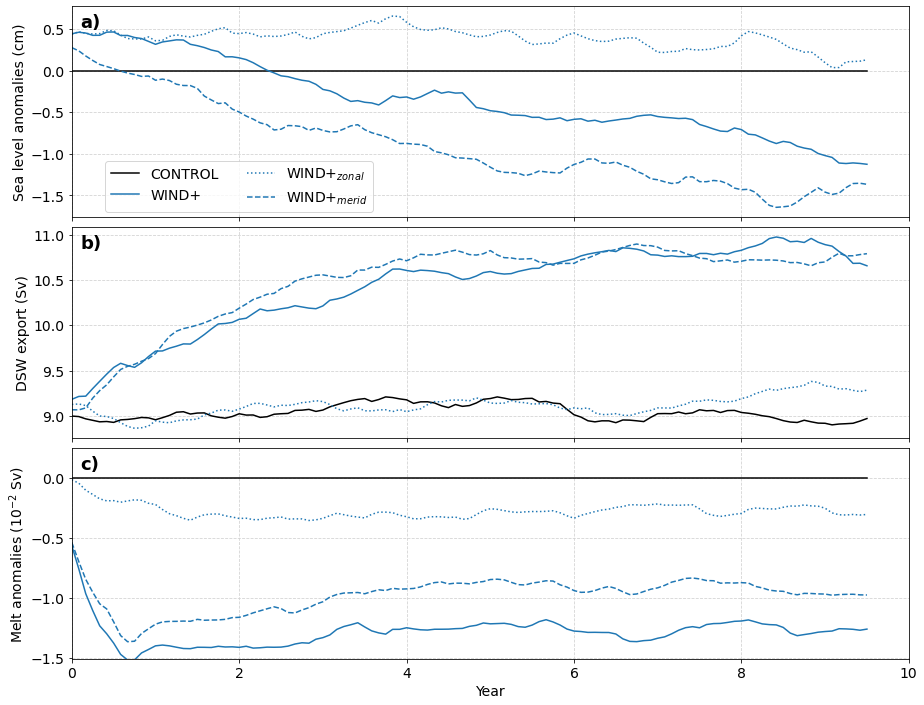

In [37]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 12))
axs = [fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)]
plt.subplots_adjust(hspace = 0.05)

for ax, lb in zip(axs, ['a)', 'b)', 'c)']):
    ax.text(0.01, 0.9, lb, transform = ax.transAxes, weight = 'bold', fontsize = 18)

axs[0].plot(np.arange(0, 120, 1), slev_anom_mask['up'].rolling(time = 12, center = True).mean('time').isel(time=slice(6,None))*0, 
            color = 'k', label = 'CONTROL')
for k, clr in zip(['up', 'up_zon', 'up_mer'], ['-', ':', '--']):
    axs[0].plot(np.arange(0, 120, 1), slev_anom_mask[k].rolling(time = 12, center = True).mean('time').isel(time=slice(6,None))*100, 
                color = 'C0', linestyle = clr)

axs[1].plot(np.arange(0, 120, 1), DSW_export_ct.rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[1].plot(np.arange(0, 120, 1), DSW_export_up.rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', label = 'WIND+')
axs[1].plot(np.arange(0, 120, 1), DSW_export_upz.rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[1].plot(np.arange(0, 120, 1), DSW_export_upm.rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')
    
axs[1].legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.2,1.35))

axs[2].plot(np.arange(0, 120, 1), melt_eup.rolling(time = 12, center = True).mean('time').isel(time=slice(6,None))*0, 
            color = 'k')
axs[2].plot(np.arange(0, 120, 1), (melt_eup-melt_control).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None))*1e2, 
            color = 'C0')
axs[2].plot(np.arange(0, 120, 1), (melt_up_zonal-melt_control).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None))*1e2, 
            color = 'C0', linestyle = ':')
axs[2].plot(np.arange(0, 120, 1), (melt_up_meridional-melt_control).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None))*1e2, 
            color = 'C0', linestyle = '--')

axs[0].set_xlim(0,120)
axs[1].set_xlim(0,120)
axs[2].set_xlim(0,120)
axs[2].set_ylim(-1.51, 0.25)
axs[0].set_xticks(np.arange(0, 144, 24))
axs[1].set_xticks(np.arange(0, 144, 24))
axs[2].set_xticks(np.arange(0, 144, 24))
axs[2].set_xticklabels(np.arange(0, 12, 2))
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[2].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('Sea level anomalies (cm)')
axs[2].set_xlabel('Year')
axs[1].set_ylabel('DSW export (Sv)')
axs[2].set_ylabel('Melt anomalies (10$^{-2}$ Sv)')

plt.savefig(figdir+'Figure8.pdf', bbox_inches = 'tight')